In [1]:
!pip install torch torchvision torchaudio 

In [2]:
import torch
import torchvision
from torchvision import transforms
#from data_preprocessing import df_detail_class_clean,df_lable_clean,patient_info_table,combined_series_dicom_datasets




In [3]:
from torchvision.datasets import ImageFolder

In [4]:
# --- Function to Get All DICOM File Paths in a Directory ---
def get_dicom_paths(directory_path, label=""):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.
    Displays count for overview.
    
    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str): Optional label (e.g. 'train', 'test')

    Returns:
    - List of paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.endswith('.dcm')
    ]
    display(HTML(f"<strong>Number of images present in the {label} directory is {len(dicom_paths)}</strong>"))
    return dicom_paths


In [5]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 

In [6]:
# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


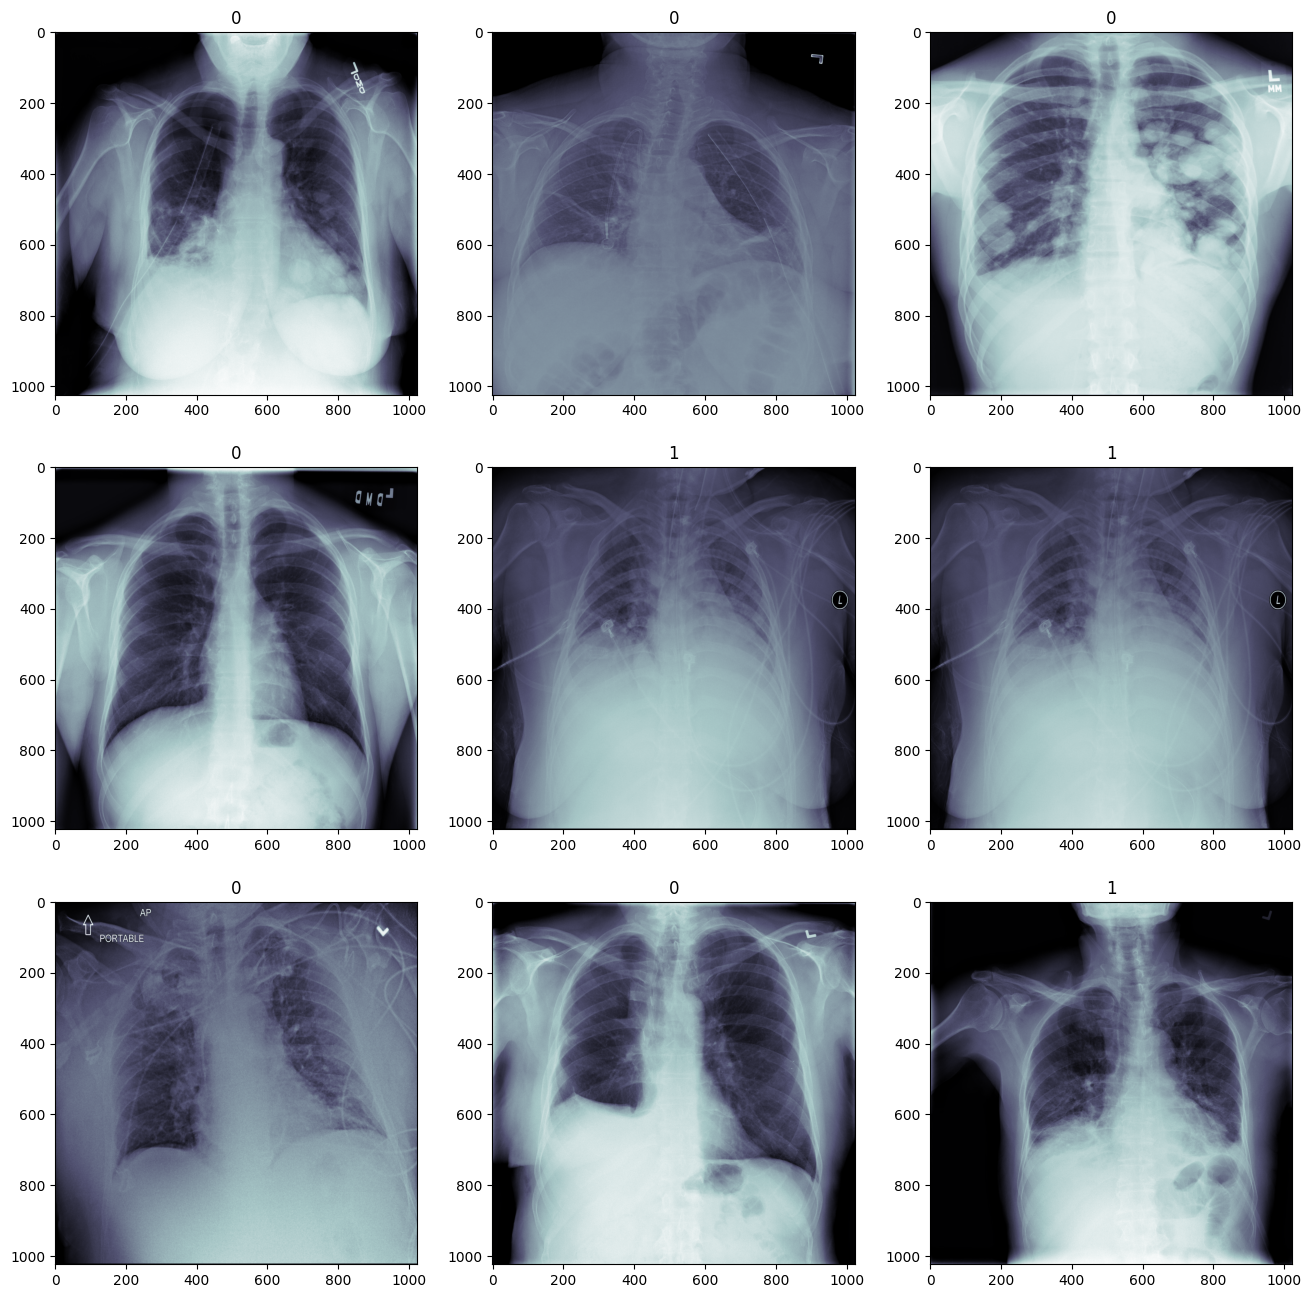

In [16]:
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt

TRAIN_IMG_DIR = Path(TRAIN_IMG_DIR)  # make sure this is a Path

fig, axis = plt.subplots(3, 3, figsize=(16, 16))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = TRAIN_IMG_DIR / f"{patient_id}.dcm"
        
        dcm = pydicom.dcmread(dcm_path).pixel_array  # fixed here
        label = labels['Target'].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(str(label))
        c += 1


In [20]:
import numpy as np
from pathlib import Path
import pydicom
import cv2
from tqdm import tqdm
SAVE_PATH=r'C:\Users\samya\PyCharmProject\Pneumonia-Detection\test'
sums, sums_squared = 0, 0

# Ensure TRAIN_IMG_DIR and SAVE_PATH are Path objects
TRAIN_IMG_DIR = Path(TRAIN_IMG_DIR)
SAVE_PATH = Path(SAVE_PATH)

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = TRAIN_IMG_DIR / f"{patient_id}.dcm"
    
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  #  use dcmread instead of read_file
    
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    label = labels.Target.iloc[c]
    
    train_or_val = 'train' if c < 24000 else 'val'
    
    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path / f"{patient_id}.npy", dcm_array)
    
    if train_or_val == "train":
        normalizer = 224 * 224
        sums += np.sum(dcm_array) / normalizer
        sums_squared += np.sum(dcm_array ** 2) / normalizer

# Compute mean and std for training set
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

mean, std


100%|██████████| 30227/30227 [12:31<00:00, 40.20it/s]


(np.float16(0.0853), np.float16(0.2316))

In [65]:
train_transforms= transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(0.0853,0.232),
    transforms.RandomAffine(degrees=(-5,5),translate=(0,0.5), scale= (0.9,1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

In [66]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.0853,0.232)
])

In [24]:
PROCESSED_DATA_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\test"


In [25]:
# Train and validation paths
train_path = os.path.join(PROCESSED_DATA_DIR, "train")
val_path   = os.path.join(PROCESSED_DATA_DIR, "val")

In [28]:
import numpy as np
from torchvision.datasets import DatasetFolder

def load_file(path):
    return np.load(path)

train_path = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection\test\train"
val_path = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection\test\val"

train_dataset = DatasetFolder(
    root=train_path,
    loader=load_file,
    extensions=("npy",),
    transform=train_transforms
)

val_dataset = DatasetFolder(
    root=val_path,
    loader=load_file,
    extensions=("npy",),
    transform=val_transforms
)


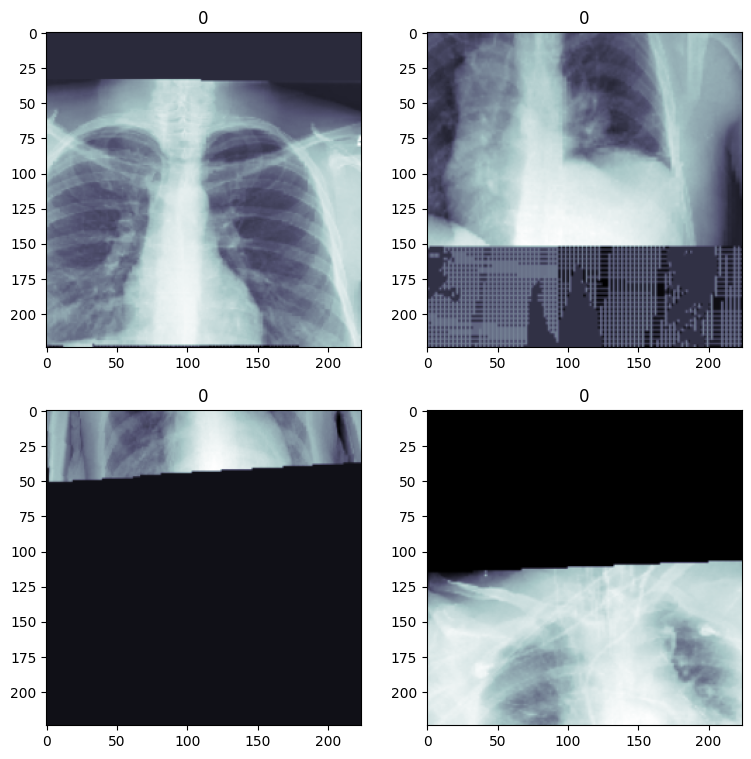

In [30]:
# Let's visualize 4 images from train dataset that are transformed 

fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

In [31]:
batch_size = 64
num_workers= 2
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, num_workers=2, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False
)


In [33]:
np.unique(train_dataset.targets, return_counts=True)


(array([0, 1]), array([16008,  4985]))

In [51]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pooling_layer = nn.MaxPool2d(2)

    def forward(self, x):  # fixed typo here
        x = self.conv_layer(x)
        x = nn.ReLU()(x)
        x = self.pooling_layer(x)
        return x


In [ ]:
class BaseLineCNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.feature_extractor = nn.Sequential(  # fixed typo here
            ConvBlock(3, 64, (3, 3)),
            ConvBlock(64, 128, (3, 3)),
            ConvBlock(128, 256, (3, 3)),
            ConvBlock(256, 512, (3, 3))
        )

        self.flatten = nn.Flatten()
        self.classification_head = nn.Sequential(
            nn.Linear(in_features=12*12*512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classification_head(x)
        return x


In [53]:
num_classes = 1
model = BaseLineCNN(num_classes=num_classes)
feature_extractor = model.feature_extractor


In [63]:

out = torch.randn(1, 3, 222, 222)


In [64]:
feature_maps=[]
for layer in feature_extractor: 
    out = layer(out)
    feature_maps.append(out)
     # Seeing if a layer has input channels and output channels 
    # This way, we can make sure it is a convolution layer
    if hasattr(layer, 'in_channels') and hasattr(layer, 'out_channels'):
        feature_maps.append(out.squeeze(dim=0).permute(1,2,0))

def see_conv(feature_map, nrows, ncols):
    """
    Visualizes feature maps from a convolution layer.
    """
    num_channels = feature_map.shape[2]
    channels = np.arange(num_channels).reshape(nrows, ncols)
    fig, ax = plt.subplots(figsize=(ncols*2, nrows*2), nrows=nrows, ncols=ncols)
    for i in range(nrows):
        for j in range(ncols):
            channel = channels[i, j]
            showfig = feature_map[:, :, channel]  # no need to expand dims for imshow
            ax[i, j].axis('off')
            ax[i, j].imshow(showfig, cmap='viridis')
    plt.tight_layout()
    plt.show()


In [54]:
model

BaseLineCNN(
  (feature_extractor): Sequential(
    (0): ConvBlock(
      (conv_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): ConvBlock(
      (conv_layer): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classification_head): Sequential(
    (0): Linear(in_features=73728, out_features=64, bias=True)
    (1): ReLU()
    (2

In [55]:
feature_extractor

Sequential(
  (0): ConvBlock(
    (conv_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): ConvBlock(
    (conv_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): ConvBlock(
    (conv_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): ConvBlock(
    (conv_layer): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)